## Basic Data Preprocessing  

### 1. 오류 데이터 처리
- member_yn = 'N'인 데이터 중에서 멤버십, 젠더 정보가 있는 경우 'Y'로 변경
  
---
### 2. 데이터 이진화
- pre_open_date, gender, member_yn 데이터 2진화 수행, gender의 경우 nan을 2로 labeling  
** pre_open_date : 예술의전당 유료회원 상대로 미리 예매를 할 수 있는 하루 전 혜택, 기획자/대관자의 선택에 의해 결정  
  
---
### 3. membership column 정리
- 6개의 membership_type 컬럼을 membership_free, membership_paid 2개의 컬럼으로 정리  
- free : 노블, 싹틔우미, 일반  
- paid : 법인, 골드, 블루, 그린, 무료로 등급을 나누어 컬럼 간소화  




In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

plt.rc('font', family = 'Malgun Gothic')
pd.set_option('display.max_columns', None)
filterwarnings('ignore')

df = pd.read_csv('./dataset/2023bigcontest_advanced_sac.csv')


In [2]:
df.head()

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn
0,50.0,F,골드,무료,그린,NaN,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,20220114.0,20220115.0,교향곡,콘서트홀,120,15,Y
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20211003,1550,20211009,2000,1층 7열 5,0,0,초대권,1120,NaN,20210823.0,독주,리사이틀홀,90,15,N
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220917,1520,20221105,2000,1층 C블록 16열 3,0,0,초대권,2283,20220911.0,20220911.0,독주,IBK챔버홀,80,15,N
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20190630,1132,20190731,2000,1층 2열 3,0,0,초대권,2798,NaN,20190701.0,독주,리사이틀홀,90,15,N
4,50.0,M,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,20220109.0,20220110.0,독주,콘서트홀,90,0,Y


## 1. memeber_yn == 'N' 오류 처리  
member_yn = 'N' 인데 멤버십, 젠더 정보가 있는 경우가 있음  
멤버십, 젠더의 정보가 있다는 것은 회원이라는 것을 의미하므로 Y로 되어야 함

In [3]:
def error_member_yn(df):
    idx = df.query('`member_yn` == "N" and `gender` == `gender`').index
    df.loc[idx,'member_yn'] = 'Y'
    
    return df

## 2. data labeling  
  
  * pre_open_date  
    값이 있다면(선예매 있는 공연) 1, 값이 없다면(선예매 없는 공연) 0

  * gender  
    여자는 1, 남자는 0, Nan은 2로 Labeling

  * member_yn
    Y는 1로 N 은 0

In [4]:
def labeling(df):
    
    # 1. pre_open_date 
    x = np.array(df.pre_open_date) # pre_open_date 값들을 numpy array배열로 변환 
    df.pre_open_date = np.where(np.isnan(x), 0, 1) # 값이 존재하면 1(선예매 O), 없으면 0(선예매 X) 으로 변환

    # 2. gender
    n = len(df)
    label = []
    for i in range(n):
        if df['gender'][i] == 'M':
            label.append(0)
        elif df['gender'][i] == 'F':
            label.append(1)
        else:
            label.append(2)
            
    df.gender = label
            
    # 3. member_yn
    x = np.array(df.member_yn)
    df.member_yn = np.where(x == 'Y', 1, 0)

    return df

## 3. membership column 정리  
  
  

In [5]:
df2 = error_member_yn(df)
df3 = labeling(df2)

In [6]:
member_df = df3.query('`member_yn` == 1')
nonmember_df = df3.query('`member_yn` == 0')

#### 유저별 membership_type 데이터에 특이사항이 있는지 확인

In [7]:
a = member_df[['membership_type_1', 'membership_type_2', 'membership_type_3', 'membership_type_4', 'membership_type_5']].values

In [8]:
# 모든 유저 데이터에 '무료'가 포함되어 있음
s = 0
for i in range(len(a)):
    s += np.where('무료' in a[i],0, 1)
s

0

In [9]:
# 유저데이터중 '싹틔우미'와 '노블'은 동시에 존재하는 경우가 존재 
s = 0
for i in range(len(a)):
    tmp = 0
    tmp += np.where('싹틔우미' in a[i],1, 0)
    tmp += np.where('노블' in a[i],1, 0)
    
    if tmp != 2:
        s += 0
    else:
        s += 1
        print(i)
        
s

46041
324834


2

In [10]:
 def membership_col_make(member_df):
    # free, paid 타입 구분
    free = ['노블', '싹틔우미', '무료'] # 무료는 알고리즘 내에서 '일반'으로 처리함
    paid = ['법인', '골드', '블루', '그린'] # 다 해당하지 않으면 무료, index가 작을수록 높은등급
    
    membership_free = []
    membership_paid = []
    # 6번 type은 모두 nan이므로 제외 
    membership_list = member_df[['age', 'membership_type_1','membership_type_2','membership_type_3','membership_type_4','membership_type_5']].values
    
    # 일반 25 이상(직장인), 싹틔우미 ~24(대학생 이하), 노블 69~
    for i in range(len(membership_list)):
        tmp_free = []
        tmp_paid = []
        m_types = membership_list[i]
        
        # 5개의 멤버십 타입중, free에 해당하는 것들을 tmp_free에 넣고 나머지는 tmp_paid에 넣음
        for j in range(1, 6):
            if m_types[j] in ['노블', '무료', '싹틔우미']:
                tmp_free.append(m_types[j])
                
            else:
                tmp_paid.append(m_types[j])
                
        # paid의 nan 중복제거
        tmp_paid = set(tmp_paid)
        
        # '무료'만 있거나 노블, 싹틔우미가 동시에 있는 경우
        if len(tmp_free) == 1 or len(tmp_free) == 3:
            # 나이정보를 결합해 입력
            if m_types[0] < 20:
                membership_free.append('싹틔우미')
                
            elif m_types[0] == 20:
                if len(tmp_paid) > 1:
                    membership_free.append('일반')
                    
                else:
                    membership_free.append('싹틔우미')
                    
            elif m_types[0] < 70:
                membership_free.append('일반')
            
            # 만약 나이정보가 없다면 '처리'를 넣어 나중에 추가처리
            else:
                if m_types[0] == m_types[0]:
                    membership_free.append('노블')
                else:
                    membership_free.append('처리')
                    
        # 이상이 없는 경우 주어진 값대로 넣어줌
        else:
            if tmp_free[0] != '무료':
                membership_free.append(tmp_free[0])
            else:
                membership_free.append(tmp_free[1])
        
        
        if len(tmp_paid) == 1: # Nan만 있다면 => 순수 무료회원
            membership_paid.append('무료')
        
        # Nan이 없다면 queue구조를 활용해 높은 등급의 멤버십만 남겨 데이터에 추가
        else: 
            queue = list(tmp_paid)
            ranking = 4
            
            while len(queue) > 1:
                x = queue.pop(0)
                
                if x in paid:
                    r = paid.index(x)
                    if r < ranking:
                        ranking = r
                        queue.append(x)
            
            membership_paid.append(queue[0])

    member_df['membership_free'] = membership_free
    member_df['membership_paid'] = membership_paid
    
    return member_df

In [11]:
member_df = membership_col_make(member_df)
member_df

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,membership_free,membership_paid
0,50.0,1,골드,무료,그린,NaN,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,1,20220115.0,교향곡,콘서트홀,120,15,1,일반,골드
4,50.0,0,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,1,20220110.0,독주,콘서트홀,90,0,1,일반,무료
5,30.0,1,블루,무료,NaN,NaN,NaN,NaN,20181124,1145,20190323,2000,1층 A블록2열 1,144000,2,블루회원 할인20%,528,1,20181119.0,교향곡,콘서트홀,100,15,1,일반,블루
8,30.0,1,골드,무료,NaN,NaN,NaN,NaN,20220114,1101,20220317,1930,1층 B블록 11열 9,56000,2,골드회원 할인20%,1631,1,20220115.0,실내악,IBK챔버홀,80,15,1,일반,골드
9,NaN,1,블루,무료,NaN,NaN,NaN,NaN,20190703,908,20190721,1700,1층 C블록17열 3,75000,0,일반,1528,0,20190413.0,클래식,콘서트홀,100,15,1,처리,블루
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920853,60.0,1,무료,그린,NaN,NaN,NaN,NaN,20210618,1509,20210704,1500,1층 A블록2열 2,90000,2,일반,887,1,20210620.0,교향곡,콘서트홀,110,20,1,일반,그린
1920855,50.0,0,무료,NaN,NaN,NaN,NaN,NaN,20230522,1729,20230613,1700,3층 A블록6열 4,10000,0,일반,2825,1,20230507.0,교향곡,콘서트홀,120,15,1,일반,무료
1920860,60.0,0,골드,무료,그린,NaN,NaN,NaN,20190222,1409,20190508,2000,1층 B블록 2열 9,15000,2,블라인드티켓 할인(1인4매)50%,49,1,20190223.0,클래식,IBK챔버홀,100,15,1,일반,골드
1920864,20.0,1,무료,싹틔우미,NaN,NaN,NaN,NaN,20221224,1223,20230408,1700,3층 B블록5열 4,21000,0,청소년(만7세~만24세/본인만)30%,313,0,20221223.0,교향곡,콘서트홀,120,0,1,싹틔우미,무료


In [12]:
nonmember_df['membership_free'] = '비회원'
nonmember_df['membership_paid'] = '비회원'

# 4. age data 결측치 보정  
- age 값이 있는 데이터들을 membership_free, membership_paid 값 별로 그룹화하여 mean값을 도출  
- age 값이 없으면서 membership_free가 있다면 free 등급별 나이평균의 나이대로 대치  
- 카이제곱 검정후에 cramer's v 적용해서 나이와 paid의 독립성 및 상관성 분석
- 결과를 토대로 age 결측 처리
- age 값이 없으면서 membership_free도 없다면 paid 등급별 나이평균의 나이대로 대치 후 나이에 맞게 free등급 부여 or 삭제(156개)

In [13]:
display(member_df.groupby('membership_free')['age'].mean())
display(member_df.groupby('membership_free')['age'].median())

membership_free
노블      71.905716
싹틔우미    21.790691
일반      45.108770
처리            NaN
Name: age, dtype: float64

membership_free
노블      70.0
싹틔우미    20.0
일반      50.0
처리       NaN
Name: age, dtype: float64

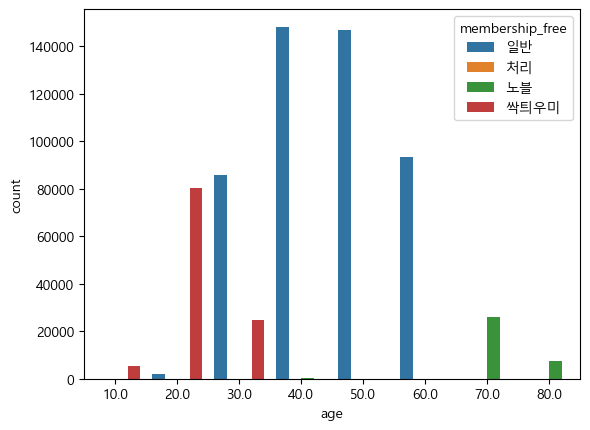

In [14]:
sns.countplot(x = 'age', hue = 'membership_free', data = member_df)
plt.show()

In [15]:
display(member_df.groupby('membership_paid')['age'].mean())
display(member_df.groupby('membership_paid')['age'].median())

membership_paid
골드    48.676782
그린    39.727118
무료    35.377232
블루    45.426045
Name: age, dtype: float64

membership_paid
골드    50.0
그린    40.0
무료    30.0
블루    50.0
Name: age, dtype: float64

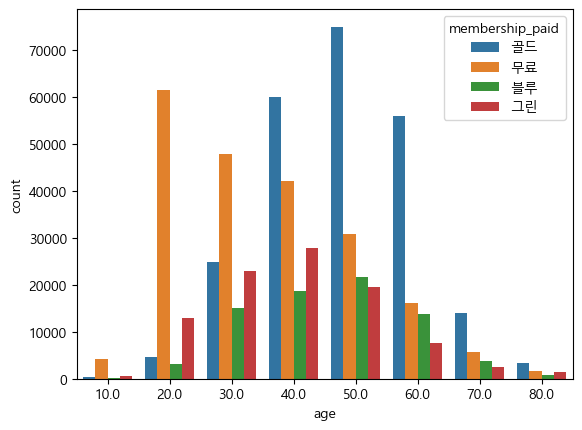

In [16]:
sns.countplot(x = 'age', hue = 'membership_paid', data = member_df)
plt.show()

In [32]:
y = member_df.groupby(['membership_paid', 'age']).count()[['gender']].reset_index()
y.pivot_table(index = 'membership_paid', columns = 'age', values = 'gender')

age,10.0,20.0,30.0,40.0,50.0,60.0,70.0,80.0
membership_paid,,,,,,,,
골드,424.0,4606.0,24909.0,59948.0,75011.0,55979.0,13902.0,3330.0
그린,545.0,12883.0,22995.0,27793.0,19561.0,7518.0,2443.0,1468.0
무료,4268.0,61567.0,47921.0,42194.0,30868.0,16138.0,5619.0,1667.0
블루,236.0,3164.0,15060.0,18619.0,21662.0,13694.0,3876.0,817.0


In [19]:
member_df.query('`membership_free` == "처리"').isnull().sum()

age                  156
gender                 0
membership_type_1      0
membership_type_2     48
membership_type_3    134
membership_type_4    154
membership_type_5    156
membership_type_6    156
tran_date              0
tran_time              0
play_date              0
play_st_time           0
seat                   0
price                  0
ticket_cancel          0
discount_type          0
performance_code       0
pre_open_date          0
open_date              0
genre                  8
place                  0
running_time           0
intermission           0
member_yn              0
membership_free        0
membership_paid        0
dtype: int64

In [16]:
member_df[['age','membership_type_1','membership_type_2','membership_type_3','membership_type_4','membership_type_5', 'membership_free', 'membership_paid']]

,age,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_free,membership_paid
0,50.0,골드,무료,그린,NaN,NaN,일반,골드
4,50.0,무료,NaN,NaN,NaN,NaN,일반,무료
5,30.0,블루,무료,NaN,NaN,NaN,일반,블루
8,30.0,골드,무료,NaN,NaN,NaN,일반,골드
9,NaN,블루,무료,NaN,NaN,NaN,처리,블루
...,...,...,...,...,...,...,...,...
1920853,60.0,무료,그린,NaN,NaN,NaN,일반,그린
1920855,50.0,무료,NaN,NaN,NaN,NaN,일반,무료
1920860,60.0,골드,무료,그린,NaN,NaN,일반,골드
1920864,20.0,무료,싹틔우미,NaN,NaN,NaN,싹틔우미,무료


In [52]:
df[df['discount_type'].str.contains('초대')].query('`price` == 30000')

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn
635327,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20220622,1339,20220626,1400,1층 A블록 17열 2,30000,2,초대권,950,1,20220519.0,실내악,IBK챔버홀,100,15,0
1491682,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20220622,1339,20220626,1400,1층 A블록 17열 3,30000,2,초대권,950,1,20220519.0,실내악,IBK챔버홀,100,15,0


In [2]:
import import_ipynb
from basic import *

# test = date_preprocess(df, 'tran_date', 'tran_time', 'tran')
# test

importing Jupyter notebook from basic.ipynb


In [3]:
t1 = error_member_yn(df)
t2 = labeling(t1)
t3 = membership_col_make(t2)

t3

,age,gender,membership_type_1,membership_type_2,membership_type_3,membership_type_4,membership_type_5,membership_type_6,tran_date,tran_time,play_date,play_st_time,seat,price,ticket_cancel,discount_type,performance_code,pre_open_date,open_date,genre,place,running_time,intermission,member_yn,membership_free,membership_paid
0,50.0,1,골드,무료,그린,NaN,NaN,NaN,20220114,1512,20220204,2000,3층 BOX9 10,10000,2,일반,302,1,20220115.0,교향곡,콘서트홀,120,15,1,일반,골드
1,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20211003,1550,20211009,2000,1층 7열 5,0,0,초대권,1120,0,20210823.0,독주,리사이틀홀,90,15,0,비회원,비회원
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20220917,1520,20221105,2000,1층 C블록 16열 3,0,0,초대권,2283,1,20220911.0,독주,IBK챔버홀,80,15,0,비회원,비회원
3,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20190630,1132,20190731,2000,1층 2열 3,0,0,초대권,2798,0,20190701.0,독주,리사이틀홀,90,15,0,비회원,비회원
4,50.0,0,무료,NaN,NaN,NaN,NaN,NaN,20220206,1615,20220302,1930,1층 B블록12열 7,180000,0,일반,897,1,20220110.0,독주,콘서트홀,90,0,1,일반,무료
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1920863,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20190614,920,20190706,1400,1층 A블록 14열 6,0,0,초대권,1265,1,20190531.0,실내악,IBK챔버홀,100,15,0,비회원,비회원
1920864,20.0,1,무료,싹틔우미,NaN,NaN,NaN,NaN,20221224,1223,20230408,1700,3층 B블록5열 4,21000,0,청소년(만7세~만24세/본인만)30%,313,0,20221223.0,교향곡,콘서트홀,120,0,1,싹틔우미,무료
1920865,50.0,1,블루,무료,그린,NaN,NaN,NaN,20210614,129,20210619,2000,1층 7열 3,24000,0,그린회원 할인20%,736,0,20210503.0,독주,리사이틀홀,100,15,1,일반,블루
1920866,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,20211123,1617,20211127,2000,1층 B블록 9열 5,0,0,초대권,1920,1,20211029.0,독주,IBK챔버홀,90,15,0,비회원,비회원
